<a href="https://colab.research.google.com/github/AndreasICL/MSc_Project/blob/master/code/VFF_and_RFF_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.2.0 > /dev/null
!pip install gpflow > /dev/null
!pip install gast > /dev/null
!pip install observations > /dev/null

In [2]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
from gpflow.covariances import Kuu
from gpflow.covariances import Kuf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
import sys
from shutil import copyfile, rmtree
import pickle 

import observations

import warnings

warnings.filterwarnings("ignore")
sys.path.insert(0,'./VFF/')

import VFF_IV
from RVFF_IV_1D import RVFF_1D

Make `tensorboard` work inside notebook:

In [3]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [4]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [5]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [6]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


In [8]:
from gpflow.conditionals import conditional

def plot(Xtest, models):

  for (mean, std, meanColour, stdColour) in models:
    plt.plot(Xtest, mean, color=meanColour)

    plt.plot(Xtest, mean + std, color=stdColour)
    plt.plot(Xtest, mean - std, color=stdColour)
    plt.fill_between(np.squeeze(Xtest), np.squeeze(mean + std), np.squeeze(mean - std), color=stdColour, alpha=0.2)
  

  plt.scatter(X, Y, s=15)

  plt.show()



#Model Definition:

###We use exact inference first

In [9]:

kernel = gpflow.kernels.Matern12(variance=0.5, lengthscales=0.5)
likelihood = gpflow.likelihoods.Gaussian()

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, True)
gpflow.utilities.set_trainable(kernel.variance, True)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

@tf.function
def loss_closure():
  return -exactModel.log_marginal_likelihood()

optimizer = gpflow.optimizers.Scipy()
result = optimizer.minimize(loss_closure, exactModel.trainable_variables, options=dict(maxiter=1000, disp=True))

print("result:")
print(result.message)

print(exactModel.log_marginal_likelihood())

Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)

# for i in range(1000):
#   if i % 200 == 0:
#     print(i)
#     print("kernel lengthscale: %2.2f" % kernel.lengthscales.read_value())
#     print("kernel variance: %2.2f" % kernel.variance.read_value())
#     print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )
#     print("=" * 70)

#   optimizer.minimize( loss=loss_closure, var_list=exactModel.trainable_variables )

# print("Exact model log p(y): %2.2f" % exactModel.log_marginal_likelihood() )

result:
b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
tf.Tensor(-68.30588480647597, shape=(), dtype=float64)


###We now use approximate inference with Random Variational Fourier Features

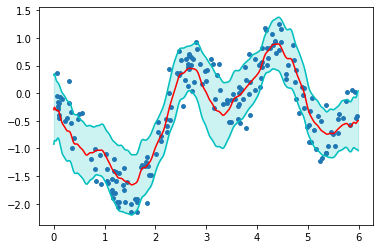

ELBO is -231.89 

Optimising...
ELBO is -151.32 
ELBO is -136.32 
ELBO is -128.96 
ELBO is -126.50 
ELBO is -126.18 
ELBO is -126.06 
ELBO is -125.84 
ELBO is -125.84 
ELBO is -125.84 
ELBO is -125.84 
Optimisation is finished!

Result message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
ELBO is -125.84 


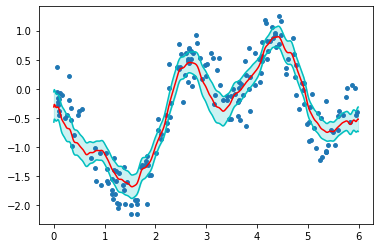

Variational Model ELBO is -125.84


In [10]:
from scipy.optimize import fmin_l_bfgs_b
from tensorflow_probability import optimizer
from tensorflow_probability import math
import copy

tf.config.experimental_run_functions_eagerly(True)

M = 100
inducing_variable = RVFF_1D( a=0, b=6, M=M, jitter=default_jitter() )

kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

model = gpflow.models.SGPR(
    (X, Y), kernel=kernel, inducing_variable=inducing_variable
)

gpflow.set_trainable(kernel.variance, True)
gpflow.set_trainable(kernel.lengthscales, True)
gpflow.set_trainable(model.likelihood, True)
gpflow.set_trainable(model.inducing_variable.a, False)
gpflow.set_trainable(model.inducing_variable.b, False)
gpflow.set_trainable(model.inducing_variable.phis, False)
gpflow.set_trainable(model.inducing_variable.omegas, False)

@tf.function
def loss_closure():
  return -model.elbo()

def callback(step, variables, values):
  print("ELBO is %2.2f " % model.elbo().numpy())

def assignParams(model, params):
  index = 0
  for var in model.trainable_variables:
    
    if var.numpy().shape == ():
      param = params[index]
      index += 1
    else:
      param = params[index:index + len(var.numpy())]
      index += len(var.numpy())
    
    var.assign(param)

def flattenParams(params):
  params = list(params)
  for i, _ in enumerate(params):
    params[i] = np.array(params[i].numpy(), dtype=default_float()).reshape(-1)
  
  result = np.concatenate(params)
  
  return tf.constant(result)

mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])
print("ELBO is %2.2f " % model.elbo().numpy())

print("\nOptimising...")
optimizer = gpflow.optimizers.Scipy()
result = optimizer.minimize(loss_closure, model.trainable_variables, method='L-BFGS-B', step_callback=callback, options=dict(maxiter=200, disp=True))
print("Optimisation is finished!\n")

print("Result message: %s" % result.message)
print("ELBO is %2.2f " % model.elbo().numpy())

mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print( "Variational Model ELBO is %3.2f" % model.elbo() )

In [11]:
# import copy 

# with tf.GradientTape() as tape:
#   tape.watch(model.inducing_variable.omegas.unconstrained_variable)
#   tape.watch(model.inducing_variable.phis.unconstrained_variable)
#   loss = -model.elbo()
# grad1, grad2, grad3 = tape.gradient( loss, [ model.inducing_variable.omegas, model.inducing_variable.phis, kernel.lengthscales ] )

# print("Gradient of omegas:")
# print(grad1)

# print("\nGradient of phis:")
# print(grad2)

# print("\nLengthscale grad: %2.2f \n" % grad3)

# for i, g in enumerate(grad2):
#   if g > 5:#1e4:
#     phi = model.inducing_variable.phis[i]
#     defaultPhis = copy.deepcopy(model.inducing_variable.phis)
#     phis = model.inducing_variable.phis
#     xs=np.arange(phi-1e-2, phi+1e-2, 1e-4)
#     y=[]
#     for x in xs:
#       phis.assign( tf.where( phis == phi, x, defaultPhis ) )
#       y.append(model.elbo())
#     break

# phis.assign(defaultPhis)

# plt.plot(xs, y)
# plt.show()

# for i, g in enumerate(grad1):
#   if g > 1e4:
#     omega = model.inducing_variable.omegas[i]
#     defaultOmegas = copy.deepcopy(model.inducing_variable.omegas)
#     omegas = model.inducing_variable.omegas
#     xs = np.arange(omega-1e-2, omega+1e-2, 1e-4)
#     y = []
#     for x in xs:
#       omegas.assign( tf.where( omegas == omega, x, defaultOmegas ) )
#       y.append(model.elbo())
#     break

# omegas.assign(defaultOmegas)

# plt.plot(xs, y)
# plt.show()

# l = kernel.lengthscales
# defaultl = copy.deepcopy(kernel.lengthscales)
# xs=np.arange(l-1e-2, l+1e-2, 1e-4)
# y=[]
# for x in xs:
#   l.assign( x )
#   y.append(model.elbo())

# l.assign(defaultl)

# plt.plot(xs, y)
# plt.show()

In [12]:
with open('./model', 'wb') as fp:
    # pickle.dump(model.trainable_parameters, fp)
    pickle.dump(inducing_variable.omegas, fp)
    pickle.dump(inducing_variable.phis, fp)
    pickle.dump(model.likelihood.variance, fp)

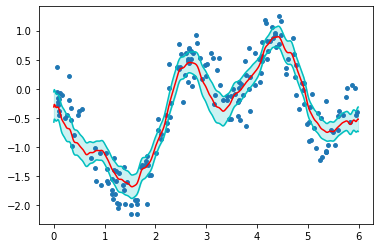

ELBO of SGPR model is -125.84
log( p( Y | θ ) ) of exact GP is -68.31


In [13]:
mean, std = model.predict_f(Xtest, False, False)
std = tf.sqrt(std)
plot(Xtest, [(mean, std, 'r', 'c')])

print("ELBO of SGPR model is %4.2f" % model.elbo().numpy())
print("log( p( Y | θ ) ) of exact GP is %4.2f" % exactModel.log_marginal_likelihood().numpy())

# Feature comparison with Variational Fourier Features

In [17]:
def getVFFmodel(VFFlength):
  if VFFlength % 2 != 1:
    return 0

  VFFlength = int((VFFlength + 1) / 2)

  kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
  VFFinducingVar = VFF_IV.FourierFeatures1D(0,6, VFFlength)
  newVFFmodel = gpflow.models.SGPR((X, Y), kernel, VFFinducingVar)

  gpflow.set_trainable(newVFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(newVFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(newVFFmodel.likelihood, True)
  gpflow.set_trainable(newVFFmodel.kernel, True)

  return newVFFmodel

def getRVFFmodel(RVFFlength):
  RVFFlength = RVFFlength

  RVFFinducingVar = RVFF_1D(a=0, b=6, M=RVFFlength)
  kernel = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

  # highestOmega = tf.math.reduce_max(RVFFmodel.inducing_variable.omegas.read_value()).numpy()
  # newOmegas = tf.concat( [ RVFFmodel.inducing_variable.omegas.read_value(), np.random.uniform(0.5 * prevLength, 0.5 * RVFFlength, numAddedFrequencies) ], axis=0 )
  # newPhis = tf.concat( [ RVFFmodel.inducing_variable.phis.read_value(), np.random.uniform(0, 2 * np.pi, numAddedFrequencies) ], axis=0 )

  # RVFFinducingVar.omegas.assign( newOmegas )
  # RVFFinducingVar.phis.assign( newPhis )

  newRVFFmodel = gpflow.models.SGPR((X, Y), kernel, RVFFinducingVar)
  # newRVFFmodel.likelihood = RVFFmodel.likelihood

  gpflow.set_trainable(newRVFFmodel.inducing_variable.a, False)
  gpflow.set_trainable(newRVFFmodel.inducing_variable.b, False)
  gpflow.set_trainable(newRVFFmodel.inducing_variable.phis, False)
  gpflow.set_trainable(newRVFFmodel.inducing_variable.omegas, False)
  gpflow.set_trainable(newRVFFmodel.likelihood, True)
  gpflow.set_trainable(newRVFFmodel.kernel, True)

  # RVFFmodel.inducing_variable = RVFFinducingVar

  return newRVFFmodel

# def getModels(numBasisFunctions):

#   if numBasisFunctions % 2 != 1:
#     return

#   kernel1 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)
#   kernel3 = gpflow.kernels.Matern12(variance=1.0, lengthscales=0.7)

#   # ==============================================================
#   # VFF model setup:
#   VFFlength = int(( numBasisFunctions + 1 ) / 2)
#   VFFinducingVar = VFF_IV.FourierFeatures1D(0, 6, VFFlength)
#   VFFmodel = gpflow.models.SGPR((X, Y), kernel1, VFFinducingVar)
#   # ==============================================================

#   # ==============================================================
#   # RVFF model, with randomly initialised frequencies:
#   RVFFlength = numBasisFunctions #2 * VFFlength - 1
#   inducing_variable = RVFF_1D( a=0, b=6, M=RVFFlength )

#   RVFFmodel = gpflow.models.SGPR( (X, Y), kernel=kernel3, inducing_variable=inducing_variable )
#   # ==============================================================

#   # ==============================================================
#   # Trainable parameters setup:
#   gpflow.set_trainable(kernel1, True)
#   gpflow.set_trainable(kernel3, True)

#   gpflow.set_trainable(VFFmodel.inducing_variable.a, False)
#   gpflow.set_trainable(VFFmodel.inducing_variable.b, False)
#   gpflow.set_trainable(VFFmodel.likelihood, True)

#   gpflow.set_trainable(RVFFmodel.inducing_variable.a, False)
#   gpflow.set_trainable(RVFFmodel.inducing_variable.b, False)
#   gpflow.set_trainable(RVFFmodel.inducing_variable.phis, False)
#   gpflow.set_trainable(RVFFmodel.inducing_variable.omegas, False)
#   gpflow.set_trainable(RVFFmodel.likelihood, True)

#   # ==============================================================

#   return VFFmodel, RVFFmodel

# ==============================================================
# Loss function:
@tf.function
def loss(model):
  def loss_closure():
    return -model.elbo()
  return loss_closure
# ==============================================================

def initializeVariables(vars):
  for var in vars:
    var.assign( tf.random.normal( shape=var.numpy().shape, mean=var, stddev=2.0, dtype=default_float() ) )

  return vars

optimizer = gpflow.optimizers.Scipy()

def train(model, maxIterPerModel, ELBOtolerance):

  print("\n===================================================================")
  print("====================== TRAINING NEW MODEL =========================")
  print("===================================================================\n")

  result = optimizer.minimize(loss(model), (model.trainable_variables), step_callback=callback, options=dict(maxiter=1000, disp=True))

  print("Result message: %s" % result.message)
  print("ELBO is %2.2f " % model.elbo().numpy())

  return model.elbo().numpy()

def transposeListOfLists(l):
  l = np.array(l)
  l = l.T
  return l.tolist()

numAddedFeatures = 2

numOfBasis = list(np.arange(21, 100, numAddedFeatures))
models = [ getVFFmodel(numOfBasis[0]), getRVFFmodel(numOfBasis[0]) ]

elbos = list()

prevELBOS = [ -1000, -1000 ]

for length in numOfBasis:
  currentELBOS = []
  print("\nCurrent number of basis functions: %3d" % length)
  for i, model in enumerate(models):
    try:
      newELBO = train(model, 10000, 10e-2)
    except:
      newELBO = train(model, 10000, 10e-2)

    # try:
    #   newELBO = train(model, 10000, 10e-2)
    # except:
    #   newELBO = -10000

    # while newELBO < prevELBOS[i]:
    #   try:
    #     mean, std = model.predict_f(Xtest, False, False)
    #     std = tf.sqrt(std)
    #     plot(Xtest, [(mean, std, 'r', 'c')])

    #     newELBO = train(model, 10000, 10e-2)
    #     print("Training terminated successfully!")

    #     mean, std = model.predict_f(Xtest, False, False)
    #     std = tf.sqrt(std)
    #     plot(Xtest, [(mean, std, 'r', 'c')])
    #   except:
    #     newELBO = -10000

    currentELBOS.append( newELBO )
  prevELBOS = list(currentELBOS)
  elbos.append(currentELBOS)
  models[0] = getVFFmodel(len(models[0].inducing_variable) + numAddedFeatures)
  models[1] = getRVFFmodel(len(models[1].inducing_variable) + numAddedFeatures)

elbos = transposeListOfLists(elbos)

VFFelbos = elbos[0]
RVFFelbos = elbos[1]

plt.plot(numOfBasis, VFFelbos)
plt.plot(numOfBasis, RVFFelbos)

plt.show()


Current number of basis functions:  21

====================== TRAINING NEW MODEL =========================

ELBO is -141.49 
ELBO is -121.34 
ELBO is -100.81 
ELBO is -96.83 
ELBO is -96.39 
ELBO is -95.95 
ELBO is -95.88 
ELBO is -95.88 
ELBO is -95.88 
ELBO is -95.88 
Result message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
ELBO is -95.88 

====================== TRAINING NEW MODEL =========================

ELBO is -121.05 
ELBO is -103.34 
ELBO is -88.77 
ELBO is -87.18 
ELBO is -86.75 
ELBO is -86.66 
ELBO is -86.50 
ELBO is -86.35 
ELBO is -86.32 
ELBO is -86.32 
ELBO is -86.32 
ELBO is -86.32 
Result message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
ELBO is -86.32 

Current number of basis functions:  23

====================== TRAINING NEW MODEL =========================

ELBO is -140.75 
ELBO is -120.86 
ELBO is -100.38 
ELBO is -96.35 
ELBO is -95.95 
ELBO is -95.58 
ELBO is -95.52 
ELBO is -95.52 
ELBO is -95.52 
ELBO is -95.52 
Result message: b'CONVE

InvalidArgumentError: ignored

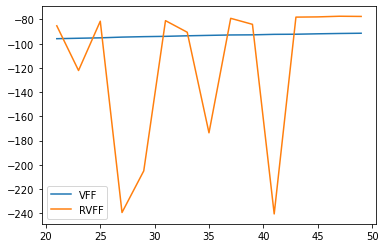

tf.Tensor(26.179938779914945, shape=(), dtype=float64)
tf.Tensor(25.352943622129434, shape=(), dtype=float64)


In [15]:
start = 0

plt.plot(numOfBasis[start:], VFFelbos[start:])
plt.plot(numOfBasis[start:], RVFFelbos[start:])
# plt.plot(numOfBasis[start:], unoptimisedRVFFelbos[start:])
plt.legend(["VFF", "RVFF"])
plt.show()

print(tf.math.reduce_max(models[0].inducing_variable.omegas))
print(tf.math.reduce_max(models[1].inducing_variable.omegas))